In [3]:
!pip install conllu sklearn_crfsuite hmmlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.9 MB/s eta 0:00:00


In [6]:
import urllib.request
from conllu import parse_incr

# Veri setini indir
def download_ud_data(url, filename):
    urllib.request.urlretrieve(url, filename)

train_url = "https://raw.githubusercontent.com/UniversalDependencies/UD_Turkish-BOUN/master/tr_boun-ud-train.conllu"
test_url = "https://raw.githubusercontent.com/UniversalDependencies/UD_Turkish-BOUN/master/tr_boun-ud-test.conllu"

download_ud_data(train_url, "tr_boun-ud-train.conllu")
download_ud_data(test_url, "tr_boun-ud-test.conllu")

# Veri setini yükle
def load_conllu_data(filepath):
    data = []
    with open(filepath, 'r', encoding='utf-8') as file:
        for tokenlist in parse_incr(file):
            words = [token['form'] for token in tokenlist]
            tags = [token['upostag'] for token in tokenlist]
            data.append((words, tags))
    return data

train_data = load_conllu_data("tr_boun-ud-train.conllu")
test_data = load_conllu_data("tr_boun-ud-test.conllu")



In [7]:
import numpy as np
from hmmlearn import hmm
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Verileri hazırlama
def prepare_hmm_data(data):
    words = []
    tags = []
    for sent_words, sent_tags in data:
        words.extend(sent_words)
        tags.extend(sent_tags)
    return words, tags

train_words, train_tags = prepare_hmm_data(train_data)
test_words, test_tags = prepare_hmm_data(test_data)

# Tag ve kelime etiketleyici
tag_encoder = LabelEncoder()
word_encoder = LabelEncoder()

train_tags_encoded = tag_encoder.fit_transform(train_tags)
train_words_encoded = word_encoder.fit_transform(train_words)

# HMM modelini eğit
model = hmm.MultinomialHMM(n_components=len(tag_encoder.classes_), n_iter=100)
model.fit(train_words_encoded.reshape(-1, 1), [len(train_words_encoded)])

# Test verilerini encode ederken bilinmeyen kelimeleri "bilinmeyen" olarak işaretle
unknown_token = "UNK"
word_encoder.classes_ = np.append(word_encoder.classes_, unknown_token)
test_words_encoded = [word_encoder.transform([word]) if word in word_encoder.classes_ else word_encoder.transform([unknown_token]) for word in test_words]
test_words_encoded = np.array([item for sublist in test_words_encoded for item in sublist])

# HMM ile tahmin yapma
def predict_hmm(model, data):
    logprob, tags_encoded = model.decode(data.reshape(-1, 1), algorithm="viterbi")
    tags = tag_encoder.inverse_transform(tags_encoded)
    return tags

predicted_tags_hmm = predict_hmm(model, test_words_encoded)

# HMM performans değerlendirme
print("HMM Model Performance")
print(classification_report(test_tags, predicted_tags_hmm))



https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


HMM Model Performance
              precision    recall  f1-score   support

         ADJ       0.00      0.00      0.00       681
         ADP       0.00      0.00      0.00       264
         ADV       0.00      0.00      0.00       479
         AUX       0.02      0.14      0.03       240
       CCONJ       0.02      0.15      0.04       337
         DET       0.00      0.00      0.00       546
        INTJ       0.00      0.00      0.00        22
        NOUN       0.32      0.17      0.22      3952
         NUM       0.02      0.13      0.03       276
        PART       0.00      0.00      0.00       162
        PRON       0.03      0.18      0.05       321
       PROPN       0.00      0.00      0.00       677
       PUNCT       0.00      0.00      0.00      2028
       SCONJ       0.00      0.00      0.00        26
        VERB       0.19      0.18      0.19      2199
           _       0.00      0.00      0.00       194

    accuracy                           0.10     12404
   m

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

# Özellik çıkarma fonksiyonu
def word2features(sent, i):
    word = sent[i]
    features = {
        'word': word,
        'is_first': i == 0,
        'is_last': i == len(sent) - 1,
        'is_capitalized': word[0].upper() == word[0],
        'is_all_caps': word.upper() == word,
        'is_all_lower': word.lower() == word,
        'prefix-1': word[0],
        'suffix-1': word[-1],
        'prefix-2': word[:2],
        'suffix-2': word[-2:],
    }
    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(tags):
    return tags

# Eğitim verilerini hazırlama
train_features = [sent2features(s) for s, t in train_data]
train_labels = [sent2labels(t) for s, t in train_data]

# Test verilerini hazırlama
test_features = [sent2features(s) for s, t in test_data]
test_labels = [sent2labels(t) for s, t in test_data]

vec = DictVectorizer(sparse=True)
X_train = vec.fit_transform([item for sublist in train_features for item in sublist])
y_train = np.concatenate(train_labels)

X_test = vec.transform([item for sublist in test_features for item in sublist])
y_test_flat = np.concatenate(test_labels)

memm = LogisticRegression(max_iter=200)
memm.fit(X_train, y_train)

# MEMM ile tahmin yapma
def predict_memm(model, features):
    X = vec.transform([item for sublist in features for item in sublist])
    y_pred = model.predict(X)
    start = 0
    y_pred_nested = []
    for feature in features:
        end = start + len(feature)
        y_pred_nested.append(y_pred[start:end])
        start = end
    return y_pred_nested

predicted_tags_memm = predict_memm(memm, test_features)

# MEMM performans değerlendirme
print("MEMM Model Performance")
print(classification_report([tag for tags in test_labels for tag in tags], [tag for tags in predicted_tags_memm for tag in tags]))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


MEMM Model Performance
              precision    recall  f1-score   support

         ADJ       0.84      0.73      0.78       681
         ADP       0.92      0.83      0.88       264
         ADV       0.83      0.78      0.81       479
         AUX       0.84      0.89      0.86       240
       CCONJ       0.95      0.89      0.92       337
         DET       0.93      0.99      0.96       546
        INTJ       0.60      0.27      0.37        22
        NOUN       0.84      0.89      0.86      3952
         NUM       0.93      0.93      0.93       276
        PART       0.73      0.98      0.84       162
        PRON       0.88      0.86      0.87       321
       PROPN       0.76      0.82      0.79       677
       PUNCT       1.00      1.00      1.00      2028
       SCONJ       0.00      0.00      0.00        26
        VERB       0.86      0.78      0.82      2199
           _       0.39      0.47      0.43       194

    accuracy                           0.87     12404
   

In [21]:
import sklearn_crfsuite
from sklearn_crfsuite import metrics

# Özellik çıkarımı fonksiyonu (örnek)
def sent2features(sent):
    return [{'word': word} for word in sent]

# Eğitim verilerini hazırlama
X_train = [sent2features(s) for s, t in train_data]
y_train = [t for s, t in train_data]

X_test = [sent2features(s) for s, t in test_data]
y_test = [t for s, t in test_data]

crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

# CRF performans değerlendirme
y_pred = crf.predict(X_test)

# Etiketleri düzleştirme
labels = list(crf.classes_)

# CRF performans değerlendirme
print("CRF Model Performance")
print(classification_report([tag for sent in y_test for tag in sent],
                            [tag for sent in y_pred for tag in sent],
                            labels=labels))


CRF Model Performance
              precision    recall  f1-score   support

         NUM       0.94      0.78      0.86       276
           _       0.69      0.37      0.48       194
        NOUN       0.75      0.90      0.82      3952
         AUX       0.84      0.88      0.86       240
       PUNCT       1.00      1.00      1.00      2028
         ADV       0.83      0.81      0.82       479
        PRON       0.95      0.87      0.90       321
        VERB       0.84      0.74      0.78      2199
         DET       0.95      0.98      0.97       546
       PROPN       0.70      0.46      0.55       677
         ADJ       0.85      0.72      0.78       681
       CCONJ       0.95      0.94      0.94       337
         ADP       0.94      0.84      0.89       264
        PART       0.81      0.98      0.89       162
       SCONJ       0.62      0.19      0.29        26
        INTJ       0.53      0.36      0.43        22
           X       0.00      0.00      0.00         0

   m

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [22]:
# HMM performans değerlendirme
print("HMM Model Performance")
print(classification_report(test_tags, predicted_tags_hmm))

# MEMM performans değerlendirme
print("MEMM Model Performance")
print(classification_report([tag for tags in test_labels for tag in tags], [tag for tags in predicted_tags_memm for tag in tags]))

# CRF performans değerlendirme
print("CRF Model Performance")
print(classification_report([tag for sent in y_test for tag in sent], [tag for sent in y_pred for tag in sent], labels=labels))


HMM Model Performance
              precision    recall  f1-score   support

         ADJ       0.00      0.00      0.00       681
         ADP       0.00      0.00      0.00       264
         ADV       0.00      0.00      0.00       479
         AUX       0.02      0.14      0.03       240
       CCONJ       0.02      0.15      0.04       337
         DET       0.00      0.00      0.00       546
        INTJ       0.00      0.00      0.00        22
        NOUN       0.32      0.17      0.22      3952
         NUM       0.02      0.13      0.03       276
        PART       0.00      0.00      0.00       162
        PRON       0.03      0.18      0.05       321
       PROPN       0.00      0.00      0.00       677
       PUNCT       0.00      0.00      0.00      2028
       SCONJ       0.00      0.00      0.00        26
        VERB       0.19      0.18      0.19      2199
           _       0.00      0.00      0.00       194

    accuracy                           0.10     12404
   m

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         ADJ       0.84      0.73      0.78       681
         ADP       0.92      0.83      0.88       264
         ADV       0.83      0.78      0.81       479
         AUX       0.84      0.89      0.86       240
       CCONJ       0.95      0.89      0.92       337
         DET       0.93      0.99      0.96       546
        INTJ       0.60      0.27      0.37        22
        NOUN       0.84      0.89      0.86      3952
         NUM       0.93      0.93      0.93       276
        PART       0.73      0.98      0.84       162
        PRON       0.88      0.86      0.87       321
       PROPN       0.76      0.82      0.79       677
       PUNCT       1.00      1.00      1.00      2028
       SCONJ       0.00      0.00      0.00        26
        VERB       0.86      0.78      0.82      2199
           _       0.39      0.47      0.43       194

    accuracy                           0.87     12404
   macro avg       0.77   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

HMM Model Performance


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

         ADJ       0.00      0.00      0.00       681
         ADP       0.00      0.00      0.00       264
         ADV       0.00      0.00      0.00       479
         AUX       0.02      0.14      0.03       240
       CCONJ       0.02      0.15      0.04       337
         DET       0.00      0.00      0.00       546
        INTJ       0.00      0.00      0.00        22
        NOUN       0.32      0.17      0.22      3952
         NUM       0.02      0.13      0.03       276
        PART       0.00      0.00      0.00       162
        PRON       0.03      0.18      0.05       321
       PROPN       0.00      0.00      0.00       677
       PUNCT       0.00      0.00      0.00      2028
       SCONJ       0.00      0.00      0.00        26
        VERB       0.19      0.18      0.19      2199
           _       0.00      0.00      0.00       194

    accuracy                           0.10     12404
   macro avg       0.04   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

              precision    recall  f1-score   support

         NUM       0.94      0.78      0.86       276
           _       0.69      0.37      0.48       194
        NOUN       0.75      0.90      0.82      3952
         AUX       0.84      0.88      0.86       240
       PUNCT       1.00      1.00      1.00      2028
         ADV       0.83      0.81      0.82       479
        PRON       0.95      0.87      0.90       321
        VERB       0.84      0.74      0.78      2199
         DET       0.95      0.98      0.97       546
       PROPN       0.70      0.46      0.55       677
         ADJ       0.85      0.72      0.78       681
       CCONJ       0.95      0.94      0.94       337
         ADP       0.94      0.84      0.89       264
        PART       0.81      0.98      0.89       162
       SCONJ       0.62      0.19      0.29        26
        INTJ       0.53      0.36      0.43        22
           X       0.00      0.00      0.00         0

   micro avg       0.84   

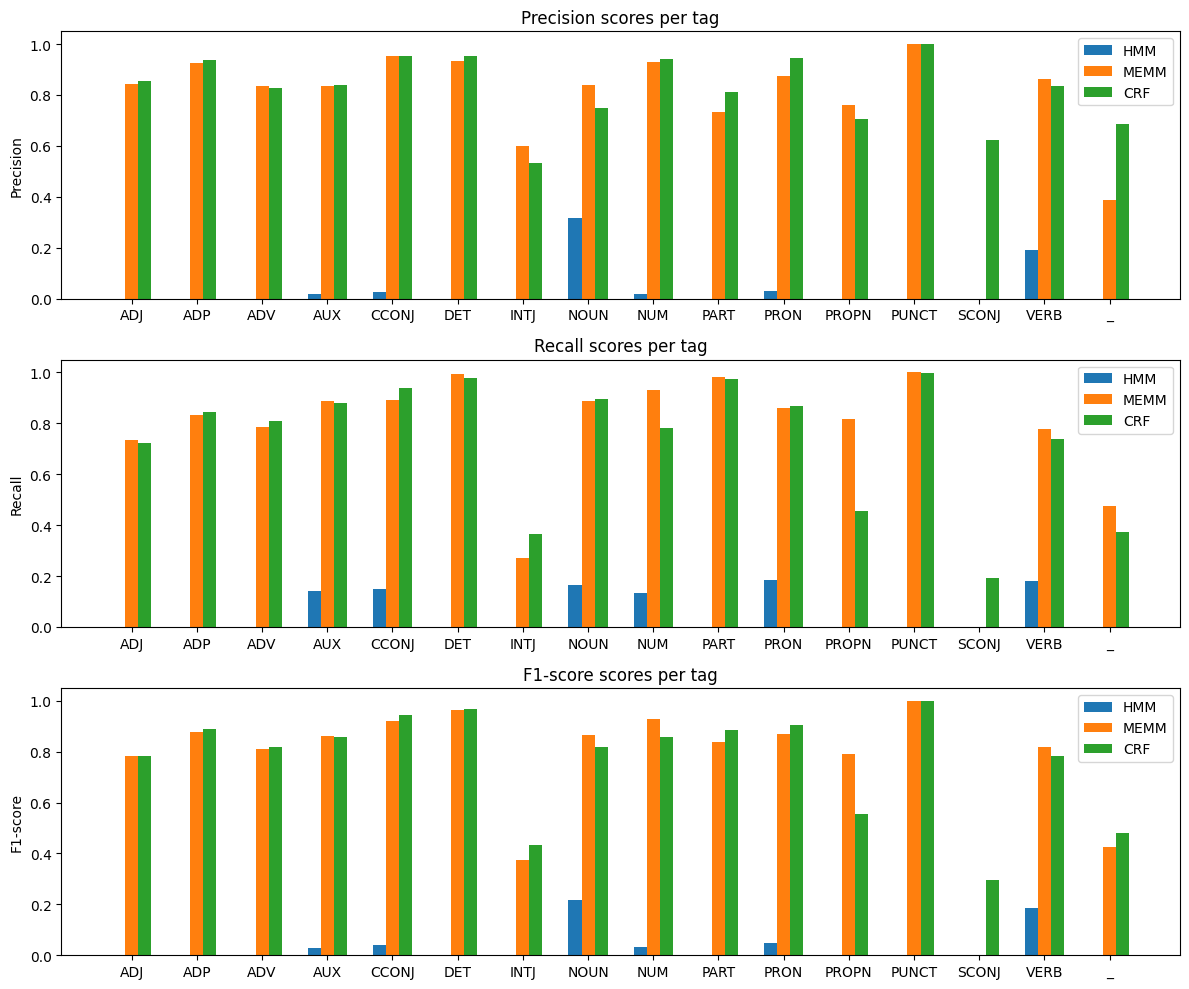

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# HMM performans değerlendirme
print("HMM Model Performance")
hmm_report = classification_report(test_tags, predicted_tags_hmm, output_dict=True)
print(classification_report(test_tags, predicted_tags_hmm))

# MEMM performans değerlendirme
print("MEMM Model Performance")
memm_report = classification_report([tag for tags in test_labels for tag in tags],
                                    [tag for tags in predicted_tags_memm for tag in tags], output_dict=True)
print(classification_report([tag for tags in test_labels for tag in tags],
                            [tag for tags in predicted_tags_memm for tag in tags]))

# CRF performans değerlendirme
print("CRF Model Performance")
crf_report = classification_report([tag for sent in y_test for tag in sent],
                                   [tag for sent in y_pred for tag in sent],
                                   labels=labels, output_dict=True)
print(classification_report([tag for sent in y_test for tag in sent],
                            [tag for sent in y_pred for tag in sent], labels=labels))

# Grafik oluşturma
models = ['HMM', 'MEMM', 'CRF']
metrics = ['precision', 'recall', 'f1-score']
tags = list(hmm_report.keys())[:-3]  # Son 3 anahtar 'accuracy', 'macro avg', 'weighted avg'

# Her model için precision, recall ve f1-score değerlerini al
hmm_scores = [[hmm_report[tag][metric] for tag in tags] for metric in metrics]
memm_scores = [[memm_report[tag][metric] for tag in tags] for metric in metrics]
crf_scores = [[crf_report[tag][metric] for tag in tags] for metric in metrics]

x = np.arange(len(tags))  # Etiketlerin sayısına göre x ekseni

width = 0.2  # Çubuk genişliği

fig, ax = plt.subplots(len(metrics), 1, figsize=(12, 10))

for i, metric in enumerate(metrics):
    ax[i].bar(x - width, hmm_scores[i], width, label='HMM')
    ax[i].bar(x, memm_scores[i], width, label='MEMM')
    ax[i].bar(x + width, crf_scores[i], width, label='CRF')

    ax[i].set_ylabel(metric.capitalize())
    ax[i].set_xticks(x)
    ax[i].set_xticklabels(tags)
    ax[i].legend(loc='best')
    ax[i].set_title(f'{metric.capitalize()} scores per tag')

fig.tight_layout()
plt.show()
